In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from modules import data_loader
from modules import metrics
from modules.gmp_model import GMP
from modules import learning
from modules import plotting
from modules import utils
import matplotlib.pyplot as plt
import numpy as np

# from modules.gmp_ar_model import GMP_NARX
# from modules.moe_ar_gmp_model import MoE_GMP_AR



Load data from files and init acpr meter

In [4]:
data = data_loader.load_data("DPA_200MHz")

config = data["config"]
fs = config["input_signal_fs"]
bw_main_ch = config["bw_main_ch"]
bw_sub_ch = config["bw_sub_ch"]
n_sub_ch = config["n_sub_ch"]
sub_ch = config["sub_ch"]
nperseg = config["nperseg"]


x_train = data["train_input"]
y_train = data["train_output"]
x_val = data["val_input"]
y_val = data["val_output"]


acpr_meter = metrics.ACPR(
        sample_rate=fs,
        main_measurement_bandwidth=bw_main_ch,
        adjacent_channel_offset=[-sub_ch, sub_ch],
        segment_length=nperseg,
        overlap_percentage=60,
        window='blackmanharris',
        fft_length=nperseg,
        power_units='dBW',
        return_main_power=True,
        return_adjacent_powers=True
    )

In [5]:
# задание целевого сигнала как k*In

gain = metrics.calculate_gain_complex(x_train, y_train)
print(f"Gain of PA = {gain:.2f}")

y_train_target = gain * x_train
y_val_target = gain * x_val



Gain of PA = 2.52


PA model

In [6]:
Ka=La=Kb=Lb=Mb=Kc=Lc=Mc=5

pa_model = GMP(Ka, La, Kb, Lb, Mb, Kc, Lc, Mc, model_type="pa_grad")

# проверка, существуют ли сохранённые коэффициенты для этого набора параметров, если нет, то они будут рассчитаны
if not pa_model.load_coefficients():
    pa_model.optimize_coefficients_grad(x_train, y_train, epochs=10000, learning_rate=0.01)
    pa_model.save_coefficients()
# else:
#     pa_model.optimize_coefficients_grad(x_train, y_train, epochs=20000, learning_rate=0.00001)
#     pa_model.save_coefficients()

y_gmp_pa = pa_model.forward(x_val).detach()

nmse_pa = metrics.compute_nmse(y_gmp_pa, y_val)
print(f"NMSE PA: {nmse_pa}")

Coefficients loaded from model_params/pa_grad_gmp_model_Ka5_La5_Kb5_Lb5_Mb5_Kc5_Lc5_Mc5.pt
NMSE PA: -33.15937423706055


c:\Users\maximp\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\signal\_spectral_py.py:652: UserWarning: Input data is complex, switching to return_onesided=False
  freqs, Pxx = csd(x, x, fs=fs, window=window, nperseg=nperseg,


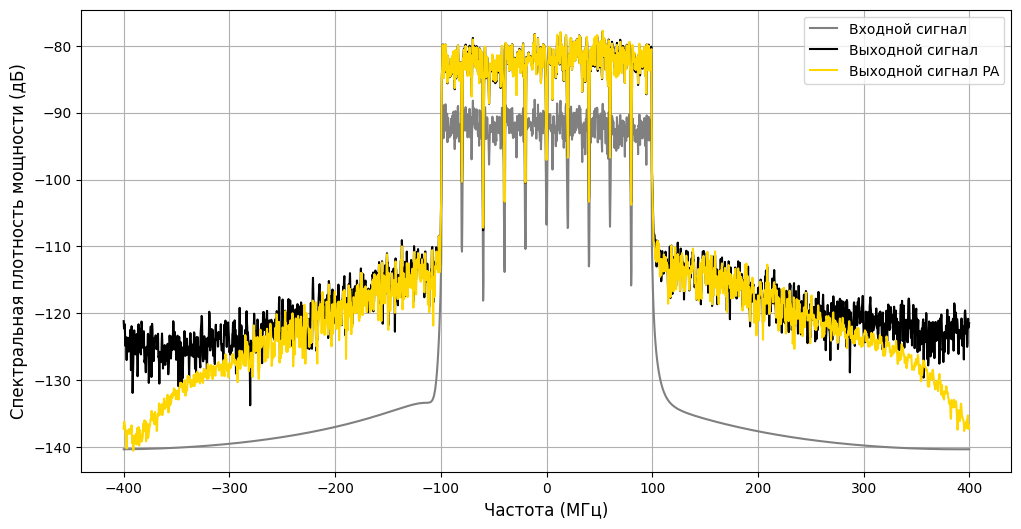

In [7]:
freqs, spectrum_y_in = metrics.power_spectrum(x_val, fs, nperseg)
_, spectrum_y_out = metrics.power_spectrum(y_val, fs, nperseg)
_, spectrum_y_gmp_pa = metrics.power_spectrum(y_gmp_pa, fs, nperseg)

xlabel="Частота (МГц)"
ylabel= "Спектральная плотность мощности (дБ)"
fontsize = 12
figsize=(12, 6)

plt.figure(figsize=figsize)

plt.plot(freqs / 1e6, 10 * np.log10(np.abs(spectrum_y_in)), color='grey', label='Входной сигнал')
plt.plot(freqs / 1e6, 10 * np.log10(np.abs(spectrum_y_out)), color='black', label='Выходной сигнал')
plt.plot(freqs / 1e6, 10 * np.log10(np.abs(spectrum_y_gmp_pa)), color='gold', label='Выходной сигнал PA')

plt.xlabel(xlabel, fontsize=fontsize)
plt.ylabel(ylabel, fontsize=fontsize)
plt.legend()
plt.grid()
plt.show()


DLA DPD grad

In [8]:
Ka=La=Kb=Lb=Mb=Kc=Lc=Mc=2

dpd_model_dla_grad = GMP(Ka, La, Kb, Lb, Mb, Kc, Lc, Mc, model_type="dpd_dla_grad")

if not dpd_model_dla_grad.load_coefficients():
    learning.optimize_dla_grad(x_train, y_train_target, dpd_model_dla_grad, pa_model, epochs=500, learning_rate=0.01)
    dpd_model_dla_grad.save_coefficients()

# else:
#     learning.optimize_dla_grad(x_train, y_train_target, dpd_model_dla_grad, pa_model, epochs=1000, learning_rate=0.001)
#     dpd_model_dla_grad.save_coefficients()

y_dpd_dla_grad = dpd_model_dla_grad.forward(x_val).detach()
y_linearized_dla_grad = pa_model.forward(y_dpd_dla_grad).detach()

nmse_dla = metrics.compute_nmse(y_linearized_dla_grad, y_val_target)
print(f"NMSE на выходе усилителя (DLA DPD): {nmse_dla}")

Coefficients loaded from model_params/dpd_dla_grad_gmp_model_Ka2_La2_Kb2_Lb2_Mb2_Kc2_Lc2_Mc2.pt
NMSE на выходе усилителя (DLA DPD): -32.05674362182617


ILA DPD grad

In [9]:
Ka=La=Kb=Lb=Mb=Kc=Lc=Mc=2

dpd_model_ila_grad = GMP(Ka, La, Kb, Lb, Mb, Kc, Lc, Mc, model_type="dpd_ila_grad")

if not dpd_model_ila_grad.load_coefficients():
    learning.optimize_ila_grad(dpd_model_ila_grad, x_train, y_train, gain, epochs=500, learning_rate=0.01)
    dpd_model_ila_grad.save_coefficients()

y_dpd_ila_grad = dpd_model_ila_grad.forward(x_val).detach()
y_linearized_ila_grad = pa_model.forward(y_dpd_ila_grad).detach()

nmse_ila = metrics.compute_nmse(y_linearized_ila_grad, y_val_target)
print(f"NMSE на выходе усилителя (ILA DPD): {nmse_ila}")


Coefficients loaded from model_params/dpd_ila_grad_gmp_model_Ka2_La2_Kb2_Lb2_Mb2_Kc2_Lc2_Mc2.pt
NMSE на выходе усилителя (ILA DPD): -31.529190063476562


ILC DPD grad

In [14]:
u_k = learning.ilc_signal_grad(x_train, y_train_target, pa_model, epochs=1000, learning_rate=0.001)

u_k_pa = pa_model.forward(u_k).detach()

Epoch [0/1000], Loss: 0.030525214970111847
Epoch [100/1000], Loss: 0.0010581662645563483
Epoch [200/1000], Loss: 2.757479524007067e-05
Epoch [300/1000], Loss: 1.1750827297873911e-06
Epoch [400/1000], Loss: 3.8611705122093554e-07
Epoch [500/1000], Loss: 1.8952907510083605e-07
Epoch [600/1000], Loss: 9.509734155699334e-08
Epoch [700/1000], Loss: 7.100277343852213e-08
Epoch [800/1000], Loss: 6.088126980330344e-08
Epoch [900/1000], Loss: 5.490905508054311e-08


In [10]:
Ka=La=Kb=Lb=Mb=Kc=Lc=Mc=2

dpd_model_ilc_grad = GMP(Ka, La, Kb, Lb, Mb, Kc, Lc, Mc, model_type="dpd_ilc_grad")

if not dpd_model_ilc_grad.load_coefficients():
    dpd_model_ilc_grad.optimize_coefficients_grad(x_train, u_k, epochs=500, learning_rate=0.01)
    dpd_model_ilc_grad.save_coefficients()

y_dpd_ilc_grad = dpd_model_ilc_grad.forward(x_val).detach()
y_linearized_ilc_grad = pa_model.forward(y_dpd_ilc_grad).detach()

nmse_ilc = metrics.compute_nmse(y_linearized_ilc_grad, y_val_target)
print(f"NMSE на выходе усилителя (ILC DPD): {nmse_ilc}")

Coefficients loaded from model_params/dpd_ilc_grad_gmp_model_Ka2_La2_Kb2_Lb2_Mb2_Kc2_Lc2_Mc2.pt
NMSE на выходе усилителя (ILC DPD): -31.894668579101562


Metrics

In [12]:
nmse_after_pa = metrics.compute_nmse(y_gmp_pa, y_val_target)

print(f"NMSE на выходе усилителя (без DPD): {nmse_after_pa:.2f} db")

print(f"NMSE на выходе усилителя (DLA DPD): {nmse_dla:.2f} db")

print(f"NMSE на выходе усилителя (ILA DPD): {nmse_ila:.2f} db")

print(f"NMSE на выходе усилителя (ILC DPD): {nmse_ilc:.2f} db")

NMSE на выходе усилителя (без DPD): -14.12 db
NMSE на выходе усилителя (DLA DPD): -32.06 db
NMSE на выходе усилителя (ILA DPD): -31.53 db
NMSE на выходе усилителя (ILC DPD): -31.89 db


In [ ]:
y_in_acpr = metrics.calculate_acpr(x_val, acpr_meter)
y_out_acpr = metrics.calculate_acpr(y_val, acpr_meter)
y_gmp_pa_acpr = metrics.calculate_acpr(y_gmp_pa, acpr_meter)
y_val_target_acpr = metrics.calculate_acpr(y_val_target, acpr_meter)

y_linearized_dla_grad_acpr = metrics.calculate_acpr(y_linearized_dla_grad, acpr_meter)
y_linearized_ila_grad_acpr = metrics.calculate_acpr(y_linearized_ila_grad, acpr_meter)
y_linearized_ilc_grad_acpr = metrics.calculate_acpr(y_linearized_ilc_grad, acpr_meter)

print(f"y_in_acpr: {y_in_acpr}")
print(f"y_out_acpr: {y_out_acpr}")
print(f"y_gmp_pa_acpr: {y_gmp_pa_acpr}")
print(f"y_val_target_acpr: {y_val_target_acpr}")

print(f"linearized_dla_grad_acpr: {y_linearized_dla_grad_acpr}")
print(f"linearized_ila_grad_acpr: {y_linearized_ila_grad_acpr}")
print(f"linearized_ilc_grad_acpr: {y_linearized_ilc_grad_acpr}")


y_in_acpr: [-42.65621373 -42.02643717]
y_out_acpr: [-34.75724292 -33.20183592]
y_gmp_pa_acpr: [-35.71297926 -33.85516117]
y_target_acpr: [-42.65621291 -42.02643707]
linearized_dla_grad_acpr: [-41.21490904 -39.80730467]
linearized_ila_grad_acpr: [-40.24267214 -36.47258004]
linearized_ilc_grad_acpr: [-40.95686863 -38.1619175 ]


In [ ]:
nmse_uk_pa = metrics.compute_nmse(u_k_pa, y_train_target)
print(f"NMSE на выходе усилителя (ILC): {nmse_uk_pa:.2f} db")

u_k_acpr = metrics.calculate_acpr(u_k, acpr_meter)
u_k_pa_acpr = metrics.calculate_acpr(u_k_pa, acpr_meter)

print(f"u_k_acpr: {u_k_acpr}")
print(f"u_k_pa_acpr: {u_k_pa_acpr}")

NMSE на выходе усилителя (ILC): -71.75 db
u_k_acpr: [-35.92053149 -36.95501355]
u_k_pa_acpr: [-40.59373831 -39.02222892]


Spectrum

In [ ]:
freqs, spectrum_y_in = metrics.power_spectrum(x_val, fs, nperseg)
_, spectrum_y_out = metrics.power_spectrum(y_val, fs, nperseg)
_, spectrum_y_gmp_pa = metrics.power_spectrum(y_gmp_pa, fs, nperseg)
_, spectrum_y_val_target = metrics.power_spectrum(y_val_target, fs, nperseg)

_, spectrum_y_dpd_dla_grad = metrics.power_spectrum(y_dpd_dla_grad, fs, nperseg)
_, spectrum_y_dpd_ila_grad = metrics.power_spectrum(y_dpd_ila_grad, fs, nperseg)
_, spectrum_y_dpd_ilc_grad = metrics.power_spectrum(y_dpd_ilc_grad, fs, nperseg)

_, spectrum_y_linearized_dla_grad = metrics.power_spectrum(y_linearized_dla_grad, fs, nperseg)
_, spectrum_y_linearized_ila_grad = metrics.power_spectrum(y_linearized_ila_grad, fs, nperseg)
_, spectrum_y_linearized_ilc_grad = metrics.power_spectrum(y_linearized_ilc_grad, fs, nperseg)


_, spectrum_u_k = metrics.power_spectrum(u_k, fs, nperseg)
_, spectrum_u_k_pa = metrics.power_spectrum(u_k_pa, fs, nperseg)

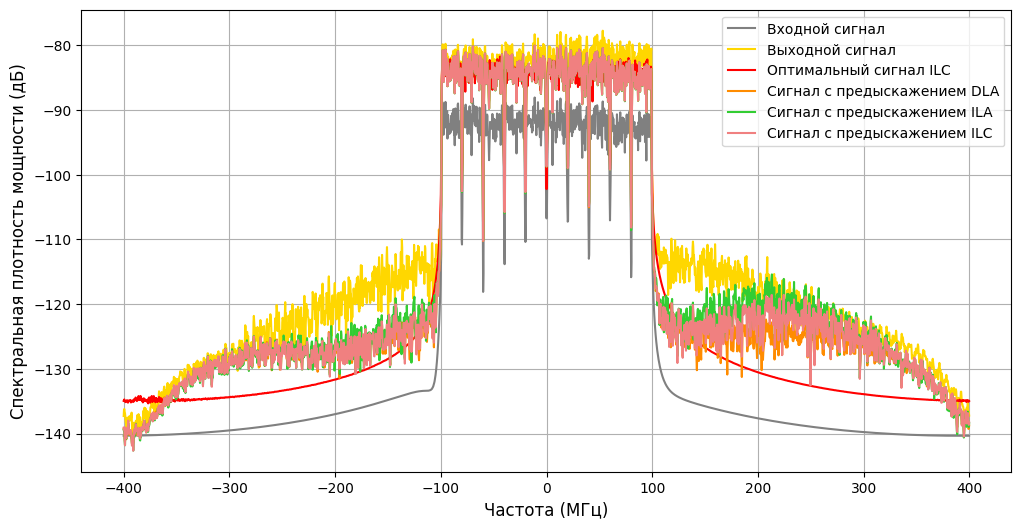

In [59]:
# построение спектра

xlabel="Частота (МГц)"
ylabel= "Спектральная плотность мощности (дБ)"
fontsize = 12
figsize=(12, 6)

plt.figure(figsize=figsize)

plt.plot(freqs / 1e6, 10 * np.log10(np.abs(spectrum_y_in)), color='grey', label='Входной сигнал')
plt.plot(freqs / 1e6, 10 * np.log10(np.abs(spectrum_y_gmp_pa)), color='gold', label='Выходной сигнал')
plt.plot(freqs / 1e6, 10 * np.log10(np.abs(spectrum_u_k_pa)), color='red', label='Оптимальный сигнал ILC')
plt.plot(freqs / 1e6, 10 * np.log10(np.abs(spectrum_y_linearized_dla_grad)), color='darkorange', label='Сигнал с предыскажением DLA')
plt.plot(freqs / 1e6, 10 * np.log10(np.abs(spectrum_y_linearized_ila_grad)), color='limegreen', label='Сигнал с предыскажением ILA')
plt.plot(freqs / 1e6, 10 * np.log10(np.abs(spectrum_y_linearized_ilc_grad)), color='lightcoral', label='Сигнал с предыскажением ILC')


plt.xlabel(xlabel, fontsize=fontsize)
plt.ylabel(ylabel, fontsize=fontsize)
plt.legend()
plt.grid()
plt.show()



In [ ]:
# moving_average
window_size = 60

freqs_s, spectrum_y_in_s = utils.moving_average(spectrum_y_in, freqs, fs, window_size)
_, spectrum_y_out_s = utils.moving_average(spectrum_y_out, freqs, fs, window_size)
_, spectrum_y_gmp_pa_s = utils.moving_average(spectrum_y_gmp_pa, freqs, fs, window_size)
_, spectrum_y_val_target_s = utils.moving_average(spectrum_y_val_target, freqs, fs, window_size)

# _, spectrum_y_dpd_dla_grad_s = utils.moving_average(spectrum_y_dpd_dla_grad, freqs, fs, window_size)
# _, spectrum_y_dpd_ila_grad_s = utils.moving_average(spectrum_y_dpd_ila_grad, freqs, fs, window_size)
# _, spectrum_y_dpd_ilc_grad_s = utils.moving_average(spectrum_y_dpd_ilc_grad, freqs, fs, window_size)

_, spectrum_y_linearized_dla_grad_s = utils.moving_average(spectrum_y_linearized_dla_grad, freqs, fs, window_size)
_, spectrum_y_linearized_ila_grad_s = utils.moving_average(spectrum_y_linearized_ila_grad, freqs, fs, window_size)
_, spectrum_y_linearized_ilc_grad_s = utils.moving_average(spectrum_y_linearized_ilc_grad, freqs, fs, window_size)

_, spectrum_u_k_s = utils.moving_average(spectrum_u_k, freqs, fs, window_size)
_, spectrum_u_k_pa_s = utils.moving_average(spectrum_u_k_pa, freqs, fs, window_size)



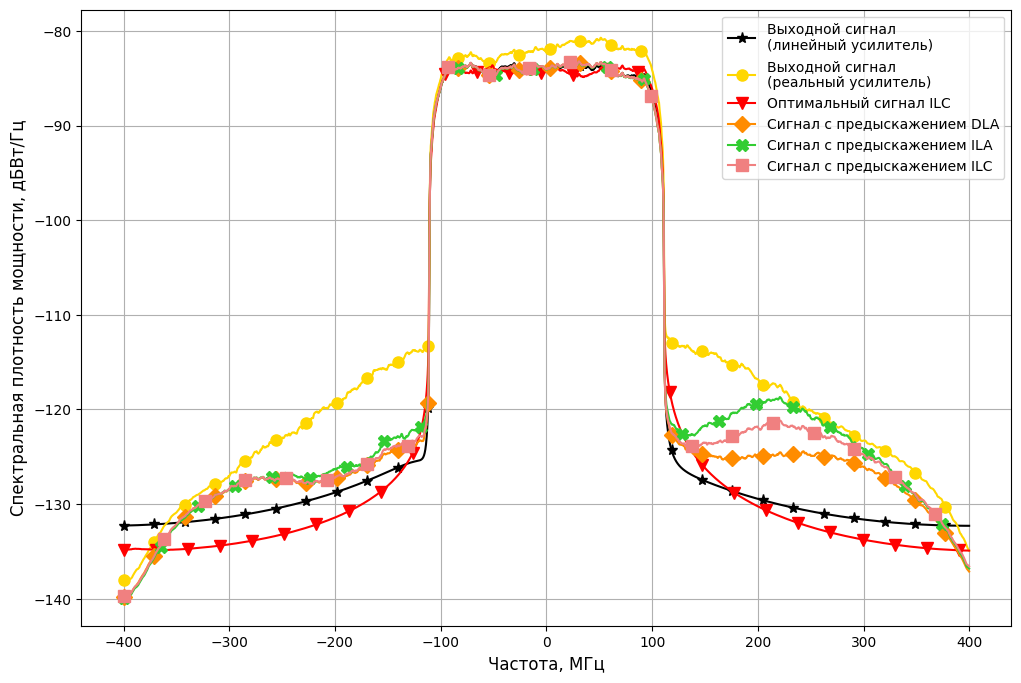

In [ ]:
# (сглаженный) построение спектра

xlabel="Частота, МГц"
ylabel= "Спектральная плотность мощности, дБВт/Гц"
fontsize = 12
figsize=(12, 8)
markersize=8

plt.figure(figsize=figsize)

# plt.plot(freqs_s / 1e6, 10 * np.log10(np.abs(spectrum_y_in_s)), 
#          color='grey', label='Входной сигнал',marker = '*', markevery=90, markersize=markersize)
plt.plot(freqs_s / 1e6, 10 * np.log10(np.abs(spectrum_y_val_target_s)), 
         color='black', label='Выходной сигнал\n(линейный усилитель)',marker = '*', markevery=90, markersize=markersize)
plt.plot(freqs_s / 1e6, 10 * np.log10(np.abs(spectrum_y_gmp_pa_s)), 
         color='gold', label='Выходной сигнал\n(реальный усилитель)', marker='o', markevery=90, markersize=markersize)
plt.plot(freqs_s / 1e6, 10 * np.log10(np.abs(spectrum_u_k_pa_s)), 
         color='red', label='Оптимальный сигнал ILC', marker='v', markevery=95, markersize=markersize)
plt.plot(freqs_s / 1e6, 10 * np.log10(np.abs(spectrum_y_linearized_dla_grad_s)), 
         color='darkorange', label='Сигнал с предыскажением DLA', marker='D', markevery=90, markersize=markersize)
plt.plot(freqs_s / 1e6, 10 * np.log10(np.abs(spectrum_y_linearized_ila_grad_s)), 
         color='limegreen', label='Сигнал с предыскажением ILA', marker='X', markevery=110, markersize=markersize)
plt.plot(freqs_s / 1e6, 10 * np.log10(np.abs(spectrum_y_linearized_ilc_grad_s)), 
         color='lightcoral', label='Сигнал с предыскажением ILC', marker='s', markevery=120, markersize=markersize)

plt.xlabel(xlabel, fontsize=fontsize)
plt.ylabel(ylabel, fontsize=fontsize)
plt.legend()
plt.grid()
plt.show()


In [ ]:
spectra = [
    (spectrum_y_in, 'grey', 'Входной сигнал'),
    # (spectrum_y_out, 'k', 'Выходной сигнал'),
    (spectrum_y_gmp_pa, 'gold', 'Выходной сигнал модели'),
    (spectrum_y_val_target, 'green', 'Идеальный линейный сигнал (k*In)'),
    # (spectrum_u_k, 'magenta', 'u_k'),
    (spectrum_u_k_pa, 'red', 'Оптимальный сигнал ILC'),
    (spectrum_y_linearized_dla_grad, 'darkorange', 'Сигнал с предыскажением DLA'),
    (spectrum_y_linearized_ila_grad, 'limegreen', 'Сигнал с предыскажением ILA'),
    (spectrum_y_linearized_ilc_grad, 'lightcoral', 'Сигнал с предыскажением ILC')
]

plotting.plot_signal_spectra(
    freqs=freqs,
    spectra=spectra,
    title='Спектр сигнала',
    xlabel='Частота (МГц)',
    ylabel='Мощность (дБ)'
)

AM/AM & AM/PM

In [ ]:
y_in_am_am, y_out_am_am = metrics.calculate_am_am(x_val, y_val)
y_in_am_pm, y_in_phase_am_pm = metrics.calculate_am_pm(x_val, y_val)

_, y_pa_am_am = metrics.calculate_am_am(x_val, y_gmp_pa)
_, y_pa_phase_am_pm = metrics.calculate_am_pm(x_val, y_gmp_pa)

_, y_val_target_am_am = metrics.calculate_am_am(x_val, y_val_target)
_, y_val_target_phase_am_pm = metrics.calculate_am_pm(x_val, y_val_target)

# x_in_am_am, u_k_am_am = metrics.calculate_am_am(x_train, u_k)
# x_in_am_pm, u_k_phase_am_pm = metrics.calculate_am_pm(x_train, u_k)

# _, u_k_pa_am_am = metrics.calculate_am_am(x_train, u_k_pa)
# _, u_k_pa_phase_am_pm = metrics.calculate_am_pm(x_train, u_k_pa)

# dpd
_, y_dpd_dla_grad_am_am = metrics.calculate_am_am(x_val, y_dpd_dla_grad)
_, y_dpd_dla_grad_phase_am_pm = metrics.calculate_am_pm(x_val, y_dpd_dla_grad)

_, y_dpd_ila_grad_am_am = metrics.calculate_am_am(x_val, y_dpd_ila_grad)
_, y_dpd_ila_grad_phase_am_pm = metrics.calculate_am_pm(x_val, y_dpd_ila_grad)

_, y_dpd_ilc_grad_am_am = metrics.calculate_am_am(x_val, y_dpd_ilc_grad)
_, y_dpd_ilc_grad_phase_am_pm = metrics.calculate_am_pm(x_val, y_dpd_ilc_grad)

#linearized
_, y_linearized_dla_grad_am_am = metrics.calculate_am_am(x_val, y_linearized_dla_grad)
_, y_linearized_dla_grad_phase_am_pm = metrics.calculate_am_pm(x_val, y_linearized_dla_grad)

_, y_linearized_ila_grad_am_am = metrics.calculate_am_am(x_val, y_linearized_ila_grad)
_, y_linearized_ila_grad_phase_am_pm = metrics.calculate_am_pm(x_val, y_linearized_ila_grad)

_, y_linearized_ilc_grad_am_am = metrics.calculate_am_am(x_val, y_linearized_ilc_grad)
_, y_linearized_ilc_grad_phase_am_pm = metrics.calculate_am_pm(x_val, y_linearized_ilc_grad)


In [44]:
#DLA

am_am_data = [
    (y_in_am_am, y_pa_am_am, 'gold', 'Выходной сигнал'),
    # (y_in_am_am, y_dpd_dla_grad_am_am, 'magenta', 'Сигнал на выходе DPD'),
    (y_in_am_am, y_linearized_dla_grad_am_am, 'darkorange', 'Сигнал с предыскажением'),
]

am_pm_data = [
    (y_in_am_pm, y_pa_phase_am_pm, 'gold', 'Выходной сигнал'),
    (y_in_am_pm, y_linearized_dla_grad_phase_am_pm, 'darkorange', 'Сигнал с предыскажением'),
]

plotting.plot_am_am_pm(
    am_am_data=am_am_data,
    am_pm_data=am_pm_data,
    figsize=(12, 6),
    titles=("AM/AM DLA", "AM/PM DLA"),
    xlabels=("Амплитуда на входе", "Амплитуда на входе"),
    ylabels=("Амплитуда на выходе", "Фазовый сдвиг на выходе (градусы)")
)



NameError: name 'y_in_am_am' is not defined

In [43]:
#ILA

am_am_data = [
    (y_in_am_am, y_pa_am_am, 'gold', 'Выходной сигнал'),
    # (y_in_am_am, y_dpd_ila_grad_am_am, 'magenta', 'Сигнал на выходе DPD'),
    (y_in_am_am, y_linearized_ila_grad_am_am, 'darkorange', 'Сигнал с предыскажением'),
]

am_pm_data = [
    (y_in_am_pm, y_pa_phase_am_pm, 'gold', 'Выходной сигнал'),
    (y_in_am_pm, y_linearized_ila_grad_phase_am_pm, 'darkorange', 'Сигнал с предыскажением'),
]

plotting.plot_am_am_pm(
    am_am_data=am_am_data,
    am_pm_data=am_pm_data,
    figsize=(12, 6),
    titles=("AM/AM ILA", "AM/PM ILA"),
    xlabels=("Амплитуда на входе", "Амплитуда на входе"),
    ylabels=("Амплитуда на выходе", "Фазовый сдвиг на выходе (градусы)")
)


NameError: name 'y_in_am_am' is not defined

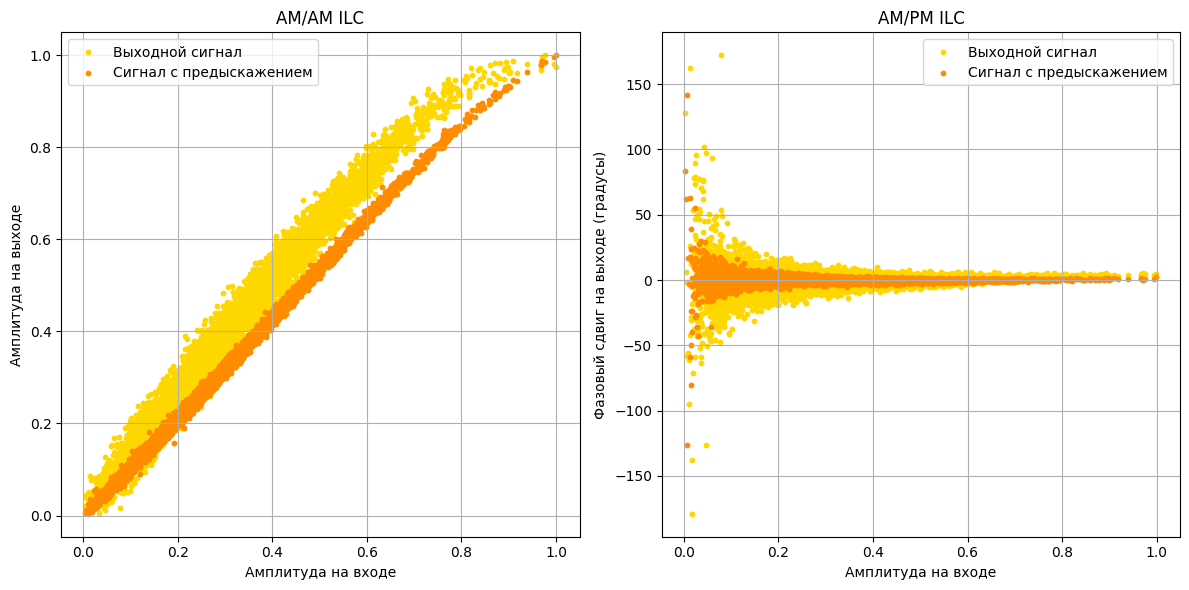

In [47]:
#ILC

am_am_data = [
    (y_in_am_am, y_pa_am_am, 'gold', 'Выходной сигнал'),
    # (y_in_am_am, y_dpd_ilc_grad_am_am, 'magenta', 'Сигнал на выходе корректора'),
    (y_in_am_am, y_linearized_ilc_grad_am_am, 'darkorange', 'Сигнал с предыскажением'),
]

am_pm_data = [
    (y_in_am_pm, y_pa_phase_am_pm, 'gold', 'Выходной сигнал'),
    (y_in_am_pm, y_linearized_ilc_grad_phase_am_pm, 'darkorange', 'Сигнал с предыскажением'),
]

plotting.plot_am_am_pm(
    am_am_data=am_am_data,
    am_pm_data=am_pm_data,
    figsize=(12, 6),
    titles=("AM/AM ILC", "AM/PM ILC"),
    xlabels=("Амплитуда на входе", "Амплитуда на входе"),
    ylabels=("Амплитуда на выходе", "Фазовый сдвиг на выходе (градусы)")
)


Add noise

In [69]:
snr_range = list(range(20, 61, 10))

Ka = La = Kb = Lb = Mb = Kc = Lc = Mc = 2
epochs = 500
lr = 0.1
num_realizations = 10

In [ ]:
nmse_dla_list = []
acpr_left_dla_list = []
acpr_right_dla_list = []

for snr in snr_range:
    print(f"Current SNR: {snr}")

    # DLA
    dpd_dla = GMP(Ka, La, Kb, Lb, Mb, Kc, Lc, Mc, model_type="dpd_dla")
    learning.optimize_dla_grad(x_train, y_train_target, dpd_dla, pa_model, epochs, lr, True, snr, fs, bw_main_ch)
    y_dla_pa = pa_model.forward(dpd_dla.forward(x_val)).detach()

    nmse_dla, acpr_left_dla, acpr_right_dla = metrics.noise_realizations(num_realizations, y_dla_pa, y_val_target, snr, fs, bw_main_ch, acpr_meter)
    nmse_dla_list.append(nmse_dla)
    acpr_left_dla_list.append(acpr_left_dla)
    acpr_right_dla_list.append(acpr_right_dla)


Current SNR: 20
Epoch [0/500], Loss: 0.37993860244750977
Epoch [100/500], Loss: 0.016325535252690315
Epoch [200/500], Loss: 0.015011824667453766
Epoch [300/500], Loss: 0.015082215890288353
Epoch [400/500], Loss: 0.01510893926024437
DLA optimization completed.
Current SNR: 30
Epoch [0/500], Loss: 0.3783438801765442
Epoch [100/500], Loss: 0.0032862445805221796
Epoch [200/500], Loss: 0.002004185924306512
Epoch [300/500], Loss: 0.0019246904412284493
Epoch [400/500], Loss: 0.0019015897996723652
DLA optimization completed.
Current SNR: 40
Epoch [0/500], Loss: 0.3804962933063507
Epoch [100/500], Loss: 0.0019168559229001403
Epoch [200/500], Loss: 0.0006502156029455364
Epoch [300/500], Loss: 0.000555136357434094
Epoch [400/500], Loss: 0.0005401097005233169
DLA optimization completed.
Current SNR: 50
Epoch [0/500], Loss: 0.37891867756843567
Epoch [100/500], Loss: 0.0017719934694468975
Epoch [200/500], Loss: 0.0005097303073853254
Epoch [300/500], Loss: 0.0004199034592602402
Epoch [400/500], Loss:

In [ ]:
nmse_ila_list = []
acpr_left_ila_list = []
acpr_right_ila_list = []

for snr in snr_range:
    print(f"Current SNR: {snr}")

    dpd_ila = GMP(Ka, La, Kb, Lb, Mb, Kc, Lc, Mc, model_type="dpd_ila")
    learning.optimize_ila_grad(dpd_ila, x_train, y_train_target, gain, epochs, lr, pa_model, True, snr, fs, bw_main_ch)
    y_ila_pa = pa_model.forward(dpd_ila.forward(x_val)).detach()

    nmse_ila, acpr_left_ila, acpr_right_ila = metrics.noise_realizations(num_realizations, y_ila_pa, y_val_target, snr, fs, bw_main_ch, acpr_meter)
    nmse_ila_list.append(nmse_ila)
    acpr_left_ila_list.append(acpr_left_ila)
    acpr_right_ila_list.append(acpr_right_ila)


Current SNR: 20
Compute on pa_model
Epoch [0/500], Loss: 0.06067666411399841
Epoch [100/500], Loss: 0.0024024092126637697
Epoch [200/500], Loss: 0.002397375414147973
Epoch [300/500], Loss: 0.002384534105658531
Epoch [400/500], Loss: 0.004197528585791588
ILA-DPD Training Complete.
Current SNR: 30
Compute on pa_model
Epoch [0/500], Loss: 0.0602751299738884
Epoch [100/500], Loss: 0.0003195448371116072
Epoch [200/500], Loss: 0.0003220894723199308
Epoch [300/500], Loss: 0.0010768179781734943
Epoch [400/500], Loss: 0.0003165686212014407
ILA-DPD Training Complete.
Current SNR: 40
Compute on pa_model
Epoch [0/500], Loss: 0.060256220400333405
Epoch [100/500], Loss: 0.00010639023093972355
Epoch [200/500], Loss: 0.0001040026982082054
Epoch [300/500], Loss: 0.00010252807987853885
Epoch [400/500], Loss: 0.00021507115161512047
ILA-DPD Training Complete.
Current SNR: 50
Compute on pa_model
Epoch [0/500], Loss: 0.06020106375217438
Epoch [100/500], Loss: 8.576515392633155e-05
Epoch [200/500], Loss: 8.1

In [ ]:
nmse_uk_list = []
acpr_left_uk_list = []
acpr_right_uk_list = []

nmse_ilc_list = []
acpr_left_ilc_list = []
acpr_right_ilc_list = []

for snr in snr_range:
    print(f"Current SNR: {snr}")
    # ILC + UK
    dpd_ilc = GMP(Ka, La, Kb, Lb, Mb, Kc, Lc, Mc, model_type="dpd_ilc")
    uk = learning.ilc_signal_grad(x_train, y_train_target, pa_model, 500, 0.001, True, snr, fs, bw_main_ch)
    
    uk_pa = pa_model.forward(uk).detach()
    nmse_uk, acpr_left_uk, acpr_right_uk = metrics.noise_realizations(num_realizations, uk_pa, y_train_target, snr, fs, bw_main_ch, acpr_meter)
    nmse_uk_list.append(nmse_uk)
    acpr_left_uk_list.append(acpr_left_uk)
    acpr_right_uk_list.append(acpr_right_uk)

    dpd_ilc.optimize_coefficients_grad(x_train, uk, epochs, lr)
    y_ilc_pa = pa_model.forward(dpd_ilc.forward(x_val)).detach()
    
    nmse_ilc, acpr_left_ilc, acpr_right_ilc = metrics.noise_realizations(num_realizations, y_ilc_pa, y_val_target, snr, fs, bw_main_ch, acpr_meter)
    nmse_ilc_list.append(nmse_ilc)
    acpr_left_ilc_list.append(acpr_left_ilc)
    acpr_right_ilc_list.append(acpr_right_ilc)

Current SNR: 20
Iteration 1/500, Loss: 0.05445856600999832
Iteration 2/500, Loss: 0.05399463325738907
Iteration 3/500, Loss: 0.05378228425979614
Iteration 4/500, Loss: 0.0529334582388401
Iteration 5/500, Loss: 0.05246075987815857
Iteration 6/500, Loss: 0.05139411240816116
Iteration 7/500, Loss: 0.050194092094898224
Iteration 8/500, Loss: 0.04913535714149475
Iteration 9/500, Loss: 0.048941195011138916
Iteration 10/500, Loss: 0.04839421436190605
Iteration 11/500, Loss: 0.04751939699053764
Iteration 12/500, Loss: 0.04666060209274292
Iteration 13/500, Loss: 0.04614448547363281
Iteration 14/500, Loss: 0.04573873057961464
Iteration 15/500, Loss: 0.04496414214372635
Iteration 16/500, Loss: 0.044177278876304626
Iteration 17/500, Loss: 0.04360545426607132
Iteration 18/500, Loss: 0.043006736785173416
Iteration 19/500, Loss: 0.04190445691347122
Iteration 20/500, Loss: 0.04221644625067711
Iteration 21/500, Loss: 0.041340116411447525
Iteration 22/500, Loss: 0.040450725704431534
Iteration 23/500, Lo

In [73]:
def tensors_to_float(tensor_list):
    float_list = [t.item() for t in tensor_list]
    return float_list

nmse_dla_list = tensors_to_float(nmse_dla_list)
nmse_ila_list = tensors_to_float(nmse_ila_list)
nmse_ilc_list = tensors_to_float(nmse_ilc_list)
nmse_uk_list = tensors_to_float(nmse_uk_list)

In [74]:
print(f"snr_range = {snr_range}")
print()

print(f"nmse_dla_list = {(nmse_dla_list)}")
print(f"acpr_left_dla_list = {acpr_left_dla_list}")
print(f"acpr_right_dla_list = {acpr_right_dla_list}")
print()

print(f"nmse_ila_list = {nmse_ila_list}")
print(f"acpr_left_ila_list = {acpr_left_ila_list}")
print(f"acpr_right_ila_list = {acpr_right_ila_list}")
print()

print(f"nmse_ilc_list = {nmse_ilc_list}")
print(f"acpr_left_ilc_list = {acpr_left_ilc_list}")
print(f"acpr_right_ilc_list = {acpr_right_ilc_list}")
print()

print(f"nmse_uk_list = {nmse_uk_list}")
print(f"acpr_left_uk_list = {acpr_left_uk_list}")
print(f"acpr_right_uk_list = {acpr_right_uk_list}")

snr_range = [20, 30, 40, 50, 60]

nmse_dla_list = [-17.056072235107422, -26.0500431060791, -31.627065658569336, -32.9353141784668, -33.089962005615234]
acpr_left_dla_list = [np.float64(-19.962427392576718), np.float64(-29.668619365183854), np.float64(-37.56287362031643), np.float64(-40.68166830381165), np.float64(-41.16875766619596)]
acpr_right_dla_list = [np.float64(-20.038332825496248), np.float64(-29.544018022384126), np.float64(-37.01118933625108), np.float64(-39.59022210487506), np.float64(-39.95638423511103)]

nmse_ila_list = [-17.014739990234375, -25.803668975830078, -31.161563873291016, -32.24973678588867, -32.356224060058594]
acpr_left_ila_list = [np.float64(-20.032400860475356), np.float64(-29.566852011432427), np.float64(-37.0746621841328), np.float64(-39.757704535602194), np.float64(-40.32800714554945)]
acpr_right_ila_list = [np.float64(-19.905485799052407), np.float64(-29.07412884120557), np.float64(-34.99187108196687), np.float64(-36.361604656467094), np.float64(-36.28125

In [24]:
# значения в виде списков чтобы не рассчитывать снова все значения

snr_range = [20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60]

nmse_dla_list = [-14.1044340133667, -16.018064498901367, -17.97743797302246, -19.84555435180664, -21.76476287841797, -23.601543426513672, -25.397140502929688, -27.051654815673828, -28.60270118713379, -29.951904296875, -31.10137939453125, -31.99922752380371, -32.693359375, -33.20136260986328, -33.556922912597656, -33.7752571105957, -33.94951248168945, -34.041229248046875, -34.11683654785156, -34.161094665527344, -34.18443298339844]
acpr_left_dla_list = [-19.98307782854365, -22.044059761313314, -24.047040241882005, -25.981348959580895, -27.975370600038946, -29.942117343851447, -31.96514345661867, -33.80510011678665, -35.72137883607495, -37.63892721922215, -39.546686668811134, -41.14783435664147, -42.72300193647455, -44.1586403570728, -45.36636102368466, -46.3075550113637, -47.042928773938236, -47.62786795374185, -48.053632118082476, -48.26038054693791, -48.41887604347718]
acpr_right_dla_list = [-20.041831052899113, -21.95478038014439, -23.98363774561688, -25.910596158467115, -27.91143197214374, -29.830851608311, -31.79363647332617, -33.5694401253062, -35.43604753655994, -37.07000947388168, -38.589720264578695, -39.981493718118756, -41.18240060456666, -42.0034433292463, -42.727465426518414, -43.28342016300996, -43.61496527628741, -43.81084719101566, -43.98201861121989, -44.08200476372817, -44.162913038570224]

nmse_ila_list = [-13.854040145874023, -15.777467727661133, -17.762771606445312, -19.657350540161133, -21.58496856689453, -23.4307918548584, -25.17462730407715, -26.818567276000977, -28.340505599975586, -29.61135482788086, -30.697265625, -31.556087493896484, -32.22067642211914, -32.64470291137695, -32.968238830566406, -33.183040618896484, -33.31875991821289, -33.422943115234375, -33.47233963012695, -33.510684967041016, -33.5294189453125]
acpr_left_ila_list = [-20.027768364406164, -22.02595135920506, -23.98453820660988, -25.961216816485567, -27.89464166886246, -29.93190200512903, -31.88604293318803, -33.82673998661604, -35.772038392214476, -37.61613725169961, -39.35554674161212, -40.999545012141596, -42.574679365583734, -43.93042452256015, -45.03867510014294, -45.908987401819914, -46.56702971768967, -47.03977254628908, -47.41264367177677, -47.67963051393086, -47.772995960135724]
acpr_right_ila_list = [-19.930579122305584, -21.869039603483063, -23.92589430272745, -25.8934186825347, -27.89435768624694, -29.824054115245037, -31.657192539039386, -33.574507705349546, -35.29508665583067, -36.91289391444029, -38.35332621280914, -39.531460585547265, -40.53575407057057, -41.37233528658536, -41.93340984815785, -42.33601701225255, -42.63072372715388, -42.78626262772036, -42.906565042070014, -42.98986099019487, -43.06106380151427]

nmse_ilc_list = [-14.0765962600708, -16.038497924804688, -17.95038604736328, -19.846113204956055, -21.75259017944336, -23.631811141967773, -25.368045806884766, -27.051647186279297, -28.601642608642578, -29.968273162841797, -31.0953426361084, -32.05195999145508, -32.759464263916016, -33.242897033691406, -33.58929443359375, -33.86418914794922, -34.00400924682617, -34.103553771972656, -34.197731018066406, -34.209129333496094, -34.251609802246094]
acpr_left_ilc_list = [-19.987904634237463, -22.032664265763948, -23.981805945312637, -25.985078180439405, -27.97285318573928, -29.932254292413706, -31.93950622504634, -33.871982256476386, -35.687000986372624, -37.643129058194496, -39.36068479051006, -41.063457267103004, -42.61319314281078, -43.93533817262031, -45.077593707598375, -46.05866500876228, -46.68572673296391, -47.206334708000576, -47.541040851625766, -47.77248651232119, -47.95394808902196]
acpr_right_ilc_list = [-19.970945068810845, -21.99232485637614, -23.99870022329292, -25.8777047238745, -27.85245425738548, -29.870087979042914, -31.71947716771799, -33.548264032512904, -35.38769115623252, -36.93997367595692, -38.44486643405877, -39.832029876134314, -40.894418612291034, -41.675168206028694, -42.37802985442333, -42.748574412828496, -43.07917614846056, -43.318133130296104, -43.473543736876735, -43.543050561279685, -43.59642567165372]

nmse_uk_list = [-14.0831298828125, -16.007923126220703, -17.956777572631836, -19.8975887298584, -21.878353118896484, -23.844219207763672, -25.788644790649414, -27.7381649017334, -29.701080322265625, -31.64846420288086, -33.609657287597656, -35.53433609008789, -37.480770111083984, -39.428749084472656, -41.34610366821289, -43.275142669677734, -45.19207000732422, -47.10540771484375, -48.99323654174805, -50.86845397949219, -52.7203369140625]
acpr_left_uk_list = [-19.998392505893012, -21.96503696465798, -23.970991167027375, -25.9149880083065, -27.92604114808463, -29.87986846158727, -31.819333935519474, -33.75500066095982, -35.68040463397734, -37.580494422986966, -39.43423352610119, -41.25160083392008, -42.91737743348149, -44.5111827081357, -45.92210941660184, -47.14031506566594, -48.14644265515601, -48.92050801676599, -49.54857485864436, -49.93755700347053, -50.273354378725]
acpr_right_uk_list = [-19.893920065196465, -21.86624051842887, -23.84565607408318, -25.75388263544563, -27.70074723690906, -29.627564553190144, -31.569643994482238, -33.43726278691267, -35.32040951826972, -37.142184428452595, -38.9831850829623, -40.66346961805266, -42.32750364604643, -43.85724713876513, -45.296073869065694, -46.486982373361776, -47.48990958237207, -48.29148483835154, -48.9249656987649, -49.38223862798154, -49.67895177822955]

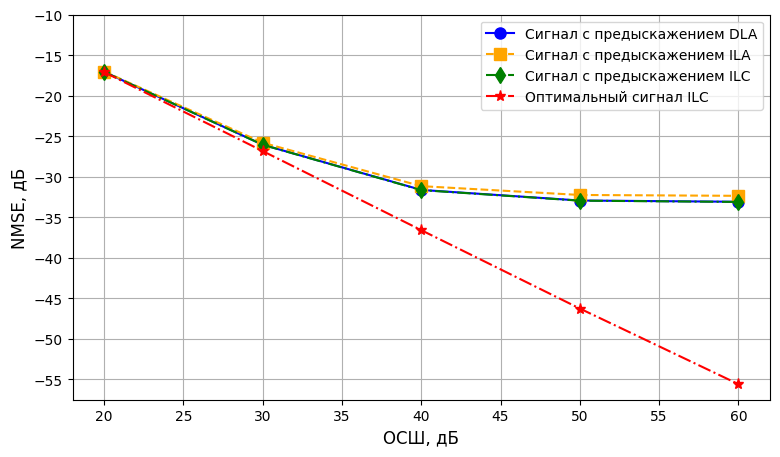

In [75]:
markersize = 8
plt.figure(figsize=(9, 5))
plt.plot(snr_range, nmse_dla_list,color='blue', linestyle='-', label="Сигнал с предыскажением DLA",
         marker='o', markersize=markersize)
plt.plot(snr_range, nmse_ila_list, color='orange', linestyle='--', label="Сигнал с предыскажением ILA",
         marker='s', markersize=markersize)
plt.plot(snr_range, nmse_ilc_list, color='green', linestyle='-.', label="Сигнал с предыскажением ILC",
         marker='d', markersize=markersize)
plt.plot(snr_range, nmse_uk_list, color='red', linestyle='-.', label="Оптимальный сигнал ILC",
         marker='*', markersize=markersize)

plt.xlabel("ОСШ, дБ", fontsize=12)
plt.ylabel("NMSE, дБ", fontsize=12)
# plt.title("Зависимость NMSE от ОСШ")
plt.xticks(range(20, 61, 5))
plt.yticks(range(-55, -9, 5))
plt.legend()
plt.grid(True)

plt.show()


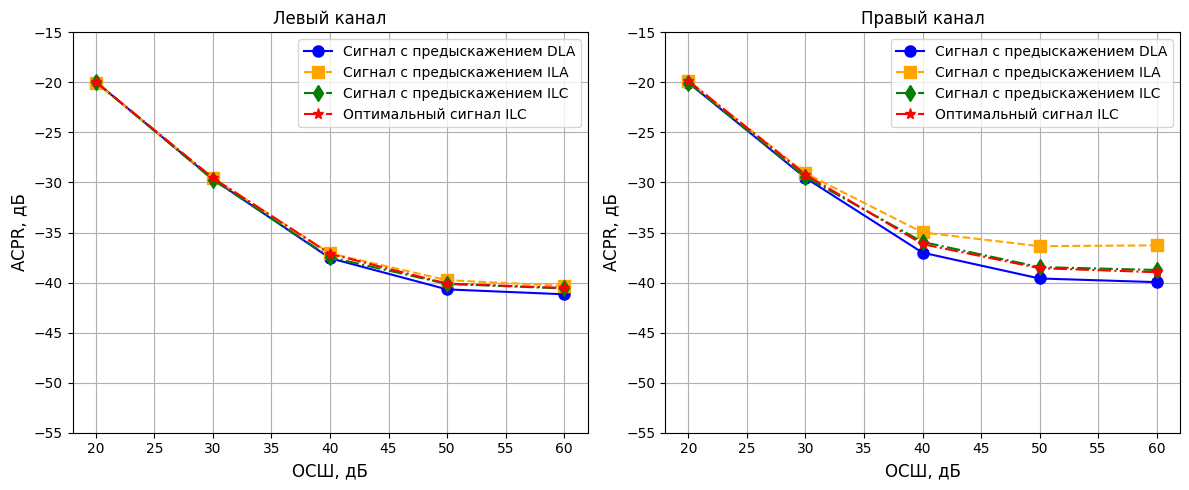

In [76]:
markersize=8
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
# plt.plot(snr_range, acpr_left_dla_list, marker='o', color='blue', linestyle='-', label="Сигнал с предыскажением DLA")
# plt.plot(snr_range, acpr_left_ila_list, marker='s', color='orange', linestyle='--', label="Сигнал с предыскажением ILA")
# plt.plot(snr_range, acpr_left_ilc_list, marker='d', color='green', linestyle='-.', label="Сигнал с предыскажением ILC")
# plt.plot(snr_range, acpr_left_uk_list, marker='*', color='indigo', linestyle='-.', label="Оптимальный сигнал ILC")
plt.plot(snr_range, acpr_left_dla_list, color='blue', linestyle='-', label="Сигнал с предыскажением DLA", 
         marker='o', markersize=markersize)
plt.plot(snr_range, acpr_left_ila_list, color='orange', linestyle='--', label="Сигнал с предыскажением ILA", 
         marker='s', markersize=markersize)
plt.plot(snr_range, acpr_left_ilc_list, color='green', linestyle='-.', label="Сигнал с предыскажением ILC", 
         marker='d', markersize=markersize)
plt.plot(snr_range, acpr_left_uk_list, color='red', linestyle='-.', label="Оптимальный сигнал ILC", 
         marker='*', markersize=markersize)
plt.title('Левый канал', fontsize=12)
plt.xlabel('ОСШ, дБ', fontsize=12)
plt.ylabel('ACPR, дБ', fontsize=12)
plt.xticks(range(20, 61, 5))
plt.yticks(range(-55, -14, 5))
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(snr_range, acpr_right_dla_list, color='blue', linestyle='-', label="Сигнал с предыскажением DLA", 
         marker='o', markersize=markersize)
plt.plot(snr_range, acpr_right_ila_list, color='orange', linestyle='--', label="Сигнал с предыскажением ILA", 
         marker='s', markersize=markersize)
plt.plot(snr_range, acpr_right_ilc_list, color='green', linestyle='-.', label="Сигнал с предыскажением ILC", 
         marker='d', markersize=markersize)
plt.plot(snr_range, acpr_right_uk_list, color='red', linestyle='-.', label="Оптимальный сигнал ILC", 
         marker='*', markersize=markersize)
plt.title('Правый канал', fontsize=12)
plt.xlabel('ОСШ, дБ', fontsize=12)
plt.ylabel('ACPR, дБ', fontsize=12)
plt.xticks(range(20, 61, 5))
plt.yticks(range(-55, -14, 5))
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()